In [4]:
%pylab inline

import math

Populating the interactive namespace from numpy and matplotlib


In [0]:
sin_wave = np.array([math.sin(x) for x in np.arange(200)])

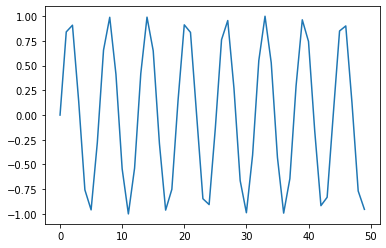

In [6]:
plt.plot(sin_wave[:50])

In [0]:
X = []
Y = []

seq_len = 50
num_records = len(sin_wave) - seq_len

for i in range(num_records - 50):
    X.append(sin_wave[i:i+seq_len])
    Y.append(sin_wave[i+seq_len])
    
X = np.array(X)
X = np.expand_dims(X, axis=2)

Y = np.array(Y)
Y = np.expand_dims(Y, axis=1)

In [9]:
X.shape, Y.shape

((100, 50, 1), (100, 1))

In [0]:
X_val = []
Y_val = []

for i in range(num_records - 50, num_records):
    X_val.append(sin_wave[i:i+seq_len])
    Y_val.append(sin_wave[i+seq_len])
    
X_val = np.array(X_val)
X_val = np.expand_dims(X_val, axis=2)

Y_val = np.array(Y_val)
Y_val = np.expand_dims(Y_val, axis=1)

In [0]:
learning_rate = 0.0001    
nepoch = 25               
T = 50                   # length of sequence
hidden_dim = 100         
output_dim = 1

bptt_truncate = 5
min_clip_value = -10
max_clip_value = 10

In [0]:
U = np.random.uniform(0, 1, (hidden_dim, T))
W = np.random.uniform(0, 1, (hidden_dim, hidden_dim))
V = np.random.uniform(0, 1, (output_dim, hidden_dim))

U : هي مصفوفة الوزن للأوزان بين الدخل والطبقات المخفية.
V : هي مصفوفة الوزن للأوزان بين الطبقات المخفية وطبقة الخرج.
W : هي مصفوفة الوزن للأوزان المشتركة في طبقة الRNN (الطبقة المخفية).
وفي النهاية، سنقوم بتعريف دالة التفعيل sigmoid، لاستخدامها في الطبقات المخفية.

In [0]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

الخطوة (2) : تدريب النموذج

الآن وقد قمنا بتعريف النموذج، نستطيع أخيرا البدء في تدريبه على تسلسل البيانات. نستطيع تقسيم خطوات التدريب لخطوات صغيرة هي :

الخطوة 2.1: التحقق من الخسارة في بيانات التدريب.
الخطوة 2.1.1: Forward pass أو تمرير للأمام.
الخطوة 2.1.2: حساب الخطأ.
الخطوة 2.2: التحقق من الخسارة في بيانات التحقق من الصحة validation data.
الخطوة 2.2.1: Forward pass.
الخطوة 2.2.2: حساب الخطأ.
الخطوة 2.3: بدء التدريب الفعلي.
الخطوة 2.3.1: Forward pass.
الخطوة 2.3.2: Backpropagate Error. 
الخطوة 2.3.3: تحديث الأوزان.
نحتاج لتكرار هذه الخطوات حتى تتقارب النتائج تقريبا، إذا بدأ الموديل بعمل overfit فربما ينبغي عليك التوقف، أو قم بإعادة تعريف أرقام الepochs.

الخطوة 2.1: التحقق من الخسارة في بيانات التدريب

سنقوم بعمل forward pass عبر نموذج الRNN، وحساب تربيع الخطأ للتنبؤات لكل السجلات records لحساب قيمة الخسارة loss value.

In [0]:
for epoch in range(nepoch):
    # check loss on train
    loss = 0.0
    
    # do a forward pass to get prediction
    for i in range(Y.shape[0]):
        x, y = X[i], Y[i]                    # get input, output values of each record
        prev_s = np.zeros((hidden_dim, 1))   # here, prev-s is the value of the previous activation of hidden layer; which is initialized as all zeroes
        for t in range(T):
            new_input = np.zeros(x.shape)    # we then do a forward pass for every timestep in the sequence
            new_input[t] = x[t]              # for this, we define a single input for that timestep
            mulu = np.dot(U, new_input)
            mulw = np.dot(W, prev_s)
            add = mulw + mulu
            s = sigmoid(add)
            mulv = np.dot(V, s)
            prev_s = s

    # calculate error 
        loss_per_record = (y - mulv)**2 / 2
        loss += loss_per_record
    loss = loss / float(y.shape[0])


الخطوة 2.2: التحقق من الخسارة في بيانات التحقق من الصحة

ونقوم بعمل نفس الشيء لحساب الخسارة في الvalidation data بيانات التحقق من الصحة.

In [15]:
# check loss on val
val_loss = 0.0
for i in range(Y_val.shape[0]):
    x, y = X_val[i], Y_val[i]
    prev_s = np.zeros((hidden_dim, 1))
    for t in range(T):
        new_input = np.zeros(x.shape)
        new_input[t] = x[t]
        mulu = np.dot(U, new_input)
        mulw = np.dot(W, prev_s)
        add = mulw + mulu
        s = sigmoid(add)
        mulv = np.dot(V, s)
        prev_s = s

    loss_per_record = (y - mulv)**2 / 2
    val_loss += loss_per_record
val_loss = val_loss / float(y.shape[0])

print('Epoch: ', epoch + 1, ', Loss: ', loss, ', Val Loss: ', val_loss)

Epoch:  25 , Loss:  [[132706.56459783]] , Val Loss:  [[66351.2554936]]


الخطوة 2.3: بدء التدريب الفعلي

في البداية نقوم بعمل forward pass لحساب الأخطاء، ثم backward pass لحساب gradients وتحديثها، دعنا نر هذا معا بالتفصيل وخطوة بخطوة لكي تتمكن من تصوره بشكل أفضل

الخطوة 2.3.1: تمرير إلى الأمام

في الforward pass 

في البداية علينا ضرب الدخل في أوزان الطبقة ما بين الدخل والطبقة الخفية.
وجمع هذا مع حاصل ضرب الأوزان في  طبقة الRNN.
وتمريره عبر دالة التفعيل sigmoid.
وضربه في الأوزان ما بين الطبقات المخفية والخرج.
في طبقة الخرج، لدينا تفعيل خطي للقيم linear activation، حتى لا نقوم بتمرير القيمة صريحة خلال طبقة التنشيط.
احفظ الحالة المتواجدة في الطبقة الحالية، وأيضا الحالة الموجودة في الطبقة السابقة في dictionary.
وهذا هو الكود للforward pass، لاحظ أنه فقط امتداد للحلقة الموجودة أعلاه.

In [0]:
# train model
for i in range(Y.shape[0]):
    x, y = X[i], Y[i]

    layers = []
    prev_s = np.zeros((hidden_dim, 1))
    dU = np.zeros(U.shape)
    dV = np.zeros(V.shape)
    dW = np.zeros(W.shape)
    
    dU_t = np.zeros(U.shape)
    dV_t = np.zeros(V.shape)
    dW_t = np.zeros(W.shape)
    
    dU_i = np.zeros(U.shape)
    dW_i = np.zeros(W.shape)
    
    # forward pass
    for t in range(T):
        new_input = np.zeros(x.shape)
        new_input[t] = x[t]
        mulu = np.dot(U, new_input)
        mulw = np.dot(W, prev_s)
        add = mulw + mulu
        s = sigmoid(add)
        mulv = np.dot(V, s)
        layers.append({'s':s, 'prev_s':prev_s})
        prev_s = s


الخطوة 2.3.2: Backpropagate Error

بعد الforward propagation، نقوم بحساب الgradients في كل طبقة، وعمل back propagate للErrors، سوف نقوم باستخدام truncated back propagation  خلال الزمن (TBPTT) بدلا من vanilla backprop. ربما تبدو مقعدة بعض الشيء ولكنها في الحقيقة بسيطة للغاية.

الفرق الأساسي بين BPTT مقارنة بال  backprop، هو أن خطوة ال backpropagation يتم تطبيقها لكل الخطوات بتغير الزمن في نموذج الRNN. وبذلك إذا كان طول التسلسل 50، فسنقوم بالنسخ الاحتياطي لكل الخطوات السابقة في الزمن حتى الوقت الحالي.

إذا كنت قد فهمت ما أعنيه، فلابد أنك استوعبت أن ال BPTT يبدو مكلف للغاية من الناحية الحسابية، ولذلك بدلا من النسخ الاحتياطي لكل الخطوات السابقة في الزمن، نقوم بالنسخ حتى x time steps أو خطوة زمنية لتوفير القوة الحسابية.

اعتبر هذه الأيدلوجية مشابهة ل stochastic gradient descent ، والتي تشمل دفعة من  البيانات بدلا من البيانات كلها.

وهذا هو الكود لعمل backpropagation Error

In [0]:
# derivative of pred
dmulv = (mulv - y)

# backward pass
for t in range(T):
    dV_t = np.dot(dmulv, np.transpose(layers[t]['s']))
    dsv = np.dot(np.transpose(V), dmulv)
    
    ds = dsv
    dadd = add * (1 - add) * ds
    
    dmulw = dadd * np.ones_like(mulw)

    dprev_s = np.dot(np.transpose(W), dmulw)


    for i in range(t-1, max(-1, t-bptt_truncate-1), -1):
        ds = dsv + dprev_s
        dadd = add * (1 - add) * ds

        dmulw = dadd * np.ones_like(mulw)
        dmulu = dadd * np.ones_like(mulu)

        dW_i = np.dot(W, layers[t]['prev_s'])
        dprev_s = np.dot(np.transpose(W), dmulw)

        new_input = np.zeros(x.shape)
        new_input[t] = x[t]
        dU_i = np.dot(U, new_input)
        dx = np.dot(np.transpose(U), dmulu)

        dU_t += dU_i
        dW_t += dW_i
        
    dV += dV_t
    dU += dU_t
    dW += dW_t


الخطوة 2.3.3: تحديث الأوزان

أخيرا نقوم بتحديث الأوزان مع تدرجات gradients الأوزان المحسوبة، أما الأمر الذي يجب أخذه في الاعتبار هو أن الgradients غالبا ما تنفجر إذا لم تقم بإبقائها قيد الفحص، وهذه مشكلة أساسية في تدريب الشبكات العصبية تدعى exploding gradient problem. لذلك علينا الإبقاء عليها في مدى محدد حتى لا تنفجر. ويمكننا فعل ذلك بالطريقة التالية :

In [0]:
    if dU.max() > max_clip_value:
        dU[dU > max_clip_value] = max_clip_value
    if dV.max() > max_clip_value:
        dV[dV > max_clip_value] = max_clip_value
    if dW.max() > max_clip_value:
        dW[dW > max_clip_value] = max_clip_value
        
    
    if dU.min() < min_clip_value:
        dU[dU < min_clip_value] = min_clip_value
    if dV.min() < min_clip_value:
        dV[dV < min_clip_value] = min_clip_value
    if dW.min() < min_clip_value:
        dW[dW < min_clip_value] = min_clip_value

# update
U -= learning_rate * dU
V -= learning_rate * dV
W -= learning_rate * dW

بدو جيدا! الآن، حان الوقت للحصول على التنبؤات، ورسمها للحصول على تصور مرئي لما قمنا به حتى الآن.

الخطوة (3) : الحصول على التنبؤات

سنقوم بعمل تمرير أمامي خلال الأوزان المدربة للحصول على التنبؤات التي نحتاجها

In [0]:
preds = []
for i in range(Y.shape[0]):
    x, y = X[i], Y[i]
    prev_s = np.zeros((hidden_dim, 1))
    # Forward pass
    for t in range(T):
        mulu = np.dot(U, x)
        mulw = np.dot(W, prev_s)
        add = mulw + mulu
        s = sigmoid(add)
        mulv = np.dot(V, s)
        prev_s = s

    preds.append(mulv)
    
preds = np.array(preds)

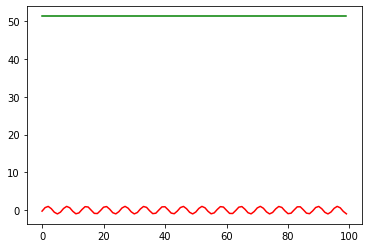

In [21]:
plt.plot(preds[:, 0, 0], 'g')
plt.plot(Y[:, 0], 'r')
plt.show()

لكن، كيف نعرف أن نموذجنا لم يحدث له overfit، هنا يأتي دور الvalidation set التي قمنا بكتابتها من قبل :

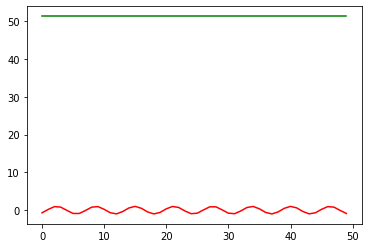

In [22]:
preds = []
for i in range(Y_val.shape[0]):
    x, y = X_val[i], Y_val[i]
    prev_s = np.zeros((hidden_dim, 1))
    # For each time step...
    for t in range(T):
        mulu = np.dot(U, x)
        mulw = np.dot(W, prev_s)
        add = mulw + mulu
        s = sigmoid(add)
        mulv = np.dot(V, s)
        prev_s = s

    preds.append(mulv)
    
preds = np.array(preds)

plt.plot(preds[:, 0, 0], 'g')
plt.plot(Y_val[:, 0], 'r')
plt.show()

ليس سيئا، تبدو التنبؤات مبهرة بشكل ما، ودرجة الRMSE لل validation set جيدة أيضا.

In [24]:
from sklearn.metrics import mean_squared_error

math.sqrt(mean_squared_error(Y_val[:, 0] * max_val, preds[:, 0, 0] * max_val))

NameError: ignored